## Read Data

In [93]:
# Adjusting and running the full analysis as described
# Importing necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

file_path = 'data/dataset_collaboration_with_survey_scores.csv'
data = pd.read_csv(file_path)

data_filtered = data[(data['project'] == 4)]
data_filtered = data_filtered[~((data_filtered['speaker_id'] == 5) | (
    data_filtered['next_speaker_id'] == 5))]

before_feedback = data_filtered[data_filtered['meeting_number'] < 10]
after_feedback = data_filtered[data_filtered['meeting_number'] >= 10]

In [94]:
num_meeting = before_feedback['speaker_id'].nunique()

## Prepare Data

In [95]:
# Function to calculate team metrics adjusted for duplicated data
def calculate_team_meeting_metrics(meetings):
    # Removing duplicates by averaging values for each speaker per meeting
    unique_speech_frequencies = meetings.groupby(['meeting_number', 'speaker_id'])[
        'normalized_speech_frequency'].mean().reset_index()

    # Summing normalized speech frequencies per meeting
    meeting_metrics = unique_speech_frequencies.groupby('meeting_number').agg({
        'normalized_speech_frequency': 'sum'
    }).reset_index()

    # Summing interaction counts per meeting
    interaction_metrics = meetings.groupby('meeting_number').agg({
        'count': 'sum',
    }).reset_index()

    # Removing self interactions
    self_interactions = meetings[meetings['speaker_id']
                                 == meetings['next_speaker_id']]
    total_self_interactions = self_interactions.groupby(
        'meeting_number')['count'].sum().reset_index()
    interaction_metrics = interaction_metrics.merge(
        total_self_interactions, on='meeting_number', how='left', suffixes=('', '_self'))
    interaction_metrics['count'] = interaction_metrics['count'] - \
        interaction_metrics['count_self'].fillna(0)
    interaction_metrics.drop(columns=['count_self'], inplace=True)

    # Combining the metrics
    combined_metrics = meeting_metrics.merge(
        interaction_metrics, on='meeting_number')

    return combined_metrics


before_feedback_metrics = calculate_team_meeting_metrics(before_feedback)
after_feedback_metrics = calculate_team_meeting_metrics(after_feedback)
before_feedback_metrics, after_feedback_metrics

(   meeting_number  normalized_speech_frequency  count
 0               1                  6062.016807    233
 1               2                  5393.385827    244
 2               3                  5103.684211    383
 3               4                  5049.000000    213
 4               5                  5401.621622    254
 5               6                  5748.965517    155
 6               7                  5074.528302    226
 7               8                  5616.617647    716
 8               9                  5627.333333   1296,
    meeting_number  normalized_speech_frequency  count
 0              10                  5753.048780    677
 1              11                  6582.699387    913
 2              12                  4808.888889    270)

## Analyzing Team Meeting Metrics: T-Test for Differences Before and After Feedback

In [96]:
# Function to perform t-tests
def perform_ttest(group1, group2):
    ttest_results = {}
    ttest_results['normalized_speech_frequency'] = ttest_ind(
        group1['normalized_speech_frequency'], group2['normalized_speech_frequency'], equal_var=False)
    ttest_results['count'] = ttest_ind(
        group1['count'], group2['count'], equal_var=False)
    return ttest_results


def dataframe_generator(ttest_results, group1, group2):
    variables = ['normalized_speech_frequency', 'count']
    rows = []
    for var in variables:
        row_meeting = {
            'Variable': var,
            'Condition': 'before',
            'Mean': group1[var].mean(),
            'Std': group1[var].std(),
            'df': len(group1[var]) - 1,
            't-statistic': ttest_results[var].statistic,
            'p-value': ttest_results[var].pvalue
        }
        row_chat = {
            'Variable': var,
            'Condition': 'after',
            'Mean': group2[var].mean(),
            'Std': group2[var].std(),
            'df': len(group2[var]) - 1,
            't-statistic': '',
            'p-value': ''
        }
        rows.append(row_meeting)
        rows.append(row_chat)

    detailed_df = pd.DataFrame(rows)
    return detailed_df


team_ttest_results = perform_ttest(
    before_feedback_metrics, after_feedback_metrics)
team_ttest_results

{'normalized_speech_frequency': TtestResult(statistic=-0.49865938637089396, pvalue=0.663369423899092, df=2.204740216915547),
 'count': TtestResult(statistic=-0.9192314831223931, pvalue=0.41092409977527106, df=3.9243956996826674)}

In [97]:
results_df = dataframe_generator(team_ttest_results,
                                 before_feedback_metrics, after_feedback_metrics)
results_df

,Variable,Condition,Mean,Std,df,t-statistic,p-value
0,normalized_speech_frequency,before,5453.017029,344.661398,8,-0.498659,0.663369
1,normalized_speech_frequency,after,5714.879019,887.521052,2,,
2,count,before,413.333333,370.838914,8,-0.919231,0.410924
3,count,after,620.000000,325.267582,2,,


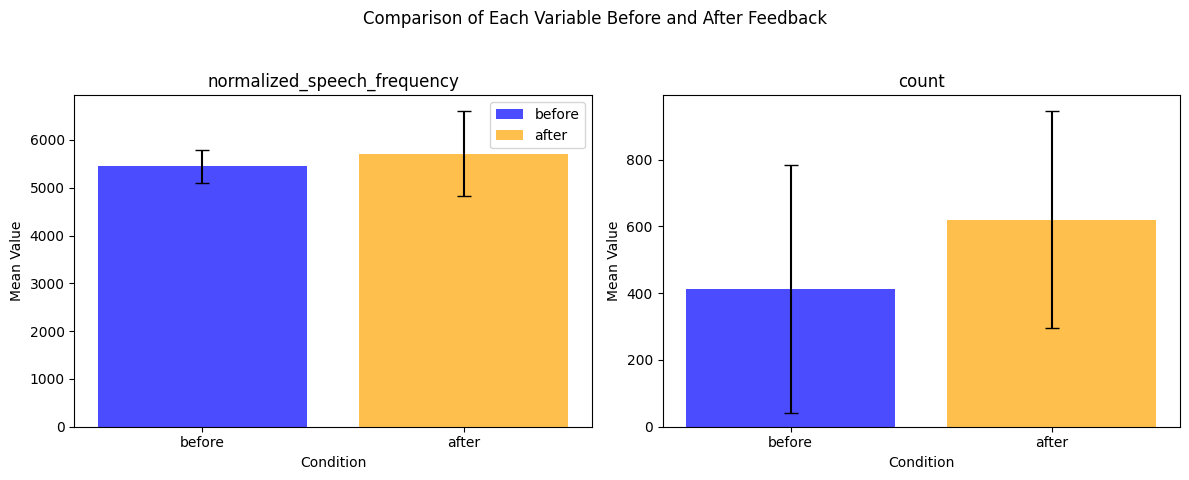

In [98]:
from matplotlib import pyplot as plt


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

color_map = {'before': 'blue', 'after': 'orange'}

variables = results_df['Variable'].unique()
for i, variable in enumerate(variables):
    subset = results_df[results_df['Variable'] == variable]
    for condition in ['before', 'after']:
        condition_data = subset[subset['Condition'] == condition]
        axes[i].bar(condition, condition_data['Mean'], yerr=condition_data['Std'],
                    capsize=5, color=color_map[condition], alpha=0.7, label=condition if i == 0 else "")
    axes[i].set_title(variable)
    axes[i].set_xlabel('Condition')
    axes[i].set_ylabel('Mean Value')
    if i == 0:
        axes[i].legend()

fig.suptitle('Comparison of Each Variable Before and After Feedback')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Calculating Individual Metrics Adjusted for Meeting Count: T-Test for Differences Before and After Feedback

In [99]:
# Function to calculate individual metrics adjusted for meeting count
def calculate_individual_metrics(meetings, meeting_count):
    # Removing duplicates by averaging values for each speaker per meeting
    unique_speech_frequencies = meetings.groupby(['meeting_number', 'speaker_id'])[
        'normalized_speech_frequency'].mean().reset_index()

    # Summing normalized speech frequencies per speaker
    individual_metrics = unique_speech_frequencies.groupby('speaker_id').agg({
        'normalized_speech_frequency': 'sum'
    }).reset_index()
    individual_metrics['normalized_speech_frequency'] /= meeting_count

    # Summing interaction counts per speaker
    interaction_metrics = meetings.groupby('speaker_id').agg({
        'count': 'sum'
    }).reset_index()

    # Removing self interactions
    self_interactions = meetings[meetings['speaker_id']
                                 == meetings['next_speaker_id']]
    total_self_interactions = self_interactions.groupby(
        'speaker_id')['count'].sum().reset_index()
    interaction_metrics = interaction_metrics.merge(
        total_self_interactions, on='speaker_id', how='left', suffixes=('', '_self'))
    interaction_metrics['count'] = interaction_metrics['count'] - \
        interaction_metrics['count_self'].fillna(0)
    interaction_metrics.drop(columns=['count_self'], inplace=True)
    interaction_metrics['count'] /= meeting_count

    # Combining the metrics
    combined_metrics = individual_metrics.merge(
        interaction_metrics, on='speaker_id')

    return combined_metrics


before_feedback_individual_metrics = calculate_individual_metrics(
    before_feedback, 9)
after_feedback_individual_metrics = calculate_individual_metrics(
    after_feedback, max(data_filtered['meeting_number'])-9)
before_feedback_individual_metrics, after_feedback_individual_metrics

(   speaker_id  normalized_speech_frequency       count
 0           0                   741.300116  101.444444
 1           1                   465.070739   74.777778
 2           2                   206.058777   26.111111
 3           3                  3717.658807  157.555556
 4           4                   322.928591   53.444444,
    speaker_id  normalized_speech_frequency       count
 0           0                  1107.869756  201.666667
 1           1                   306.990688   71.333333
 2           2                   136.206054   37.333333
 3           3                  3833.380920  231.333333
 4           4                   330.431600   78.333333)

In [100]:
individual_ttest_results = perform_ttest(
    before_feedback_individual_metrics, after_feedback_individual_metrics)

individual_ttest_results

{'normalized_speech_frequency': TtestResult(statistic=-0.054603980943287306, pvalue=0.9577956242002408, df=7.983918801249476),
 'count': TtestResult(statistic=-0.9242582614819932, pvalue=0.3887732909427246, df=6.419446384095277)}

In [101]:
results_df = dataframe_generator(individual_ttest_results,
                                 before_feedback_individual_metrics, after_feedback_individual_metrics)
results_df

,Variable,Condition,Mean,Std,df,t-statistic,p-value
0,normalized_speech_frequency,before,1090.603406,1482.098834,4,-0.054604,0.957796
1,normalized_speech_frequency,after,1142.975804,1550.177139,4,,
2,count,before,82.666667,50.188779,4,-0.924258,0.388773
3,count,after,124.000000,86.491168,4,,


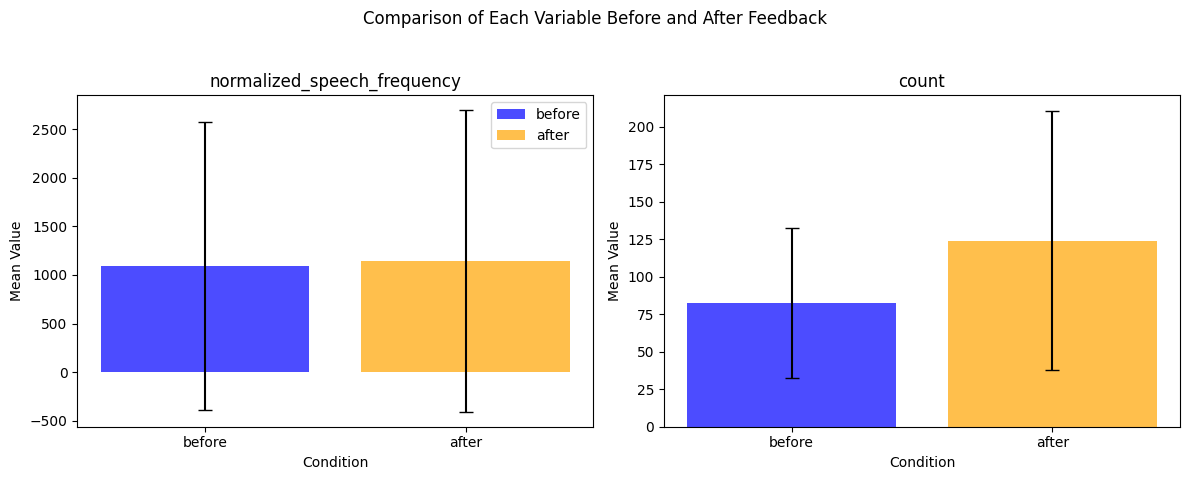

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

color_map = {'before': 'blue', 'after': 'orange'}

variables = results_df['Variable'].unique()
for i, variable in enumerate(variables):
    subset = results_df[results_df['Variable'] == variable]
    for condition in ['before', 'after']:
        condition_data = subset[subset['Condition'] == condition]
        axes[i].bar(condition, condition_data['Mean'], yerr=condition_data['Std'],
                    capsize=5, color=color_map[condition], alpha=0.7, label=condition if i == 0 else "")
    axes[i].set_title(variable)
    axes[i].set_xlabel('Condition')
    axes[i].set_ylabel('Mean Value')
    if i == 0:
        axes[i].legend()

fig.suptitle('Comparison of Each Variable Before and After Feedback')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Individual Speaker Analysis: T-Test for Differences Before and After Feedback

In [103]:
grouped_before = before_feedback.groupby(['speaker_id', 'meeting_number'])[
    'normalized_speech_frequency'].mean().reset_index()
grouped_after = after_feedback.groupby(['speaker_id', 'meeting_number'])[
    'normalized_speech_frequency'].mean().reset_index()

In [104]:

# 결과를 저장할 리스트 초기화
results = []

# 각 speaker_id에 대해 루프 실행
for speaker_id in range(num_meeting):
    before_feedback_speaker = grouped_before[grouped_before['speaker_id']
                                             == speaker_id]['normalized_speech_frequency']
    after_feedback_speaker = grouped_after[grouped_after['speaker_id']
                                           == speaker_id]['normalized_speech_frequency']
    # t-test 수행
    t_statistic, p_value = ttest_ind(
        before_feedback_speaker, after_feedback_speaker)

    mean_before = np.mean(before_feedback_speaker)
    std_before = np.std(before_feedback_speaker)
    mean_after = np.mean(after_feedback_speaker)
    std_after = np.std(after_feedback_speaker)

    df = len(before_feedback_speaker) + len(after_feedback_speaker) - 2

    results.append({
        "Speaker ID": speaker_id,
        "Condition": "Before",
        "Mean": mean_before,
        "SD": std_before,
        "t-Statistic": t_statistic,
        "df": df,
        "p-Value": p_value
    })

    results.append({
        "Speaker ID": "",
        "Condition": "After",
        "Mean": mean_after,
        "SD": std_after,
        "t-Statistic": "",
        "df": "",
        "p-Value": ""
    })

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)
results_df

,Speaker ID,Condition,Mean,SD,t-Statistic,df,p-Value
0,0,Before,741.300116,390.206339,-1.292854,10,0.225132
1,,After,1107.869756,382.306764,,,
2,1,Before,465.070739,165.603709,1.223383,10,0.24923
3,,After,306.990688,207.246193,,,
4,2,Before,206.058777,105.183232,1.045618,10,0.320354
5,,After,136.206054,16.778050,,,
6,3,Before,3717.658807,661.302247,-0.267138,10,0.794791
7,,After,3833.380920,308.953041,,,
8,4,Before,322.928591,160.657195,-0.064557,10,0.949799
9,,After,330.431600,154.520991,,,


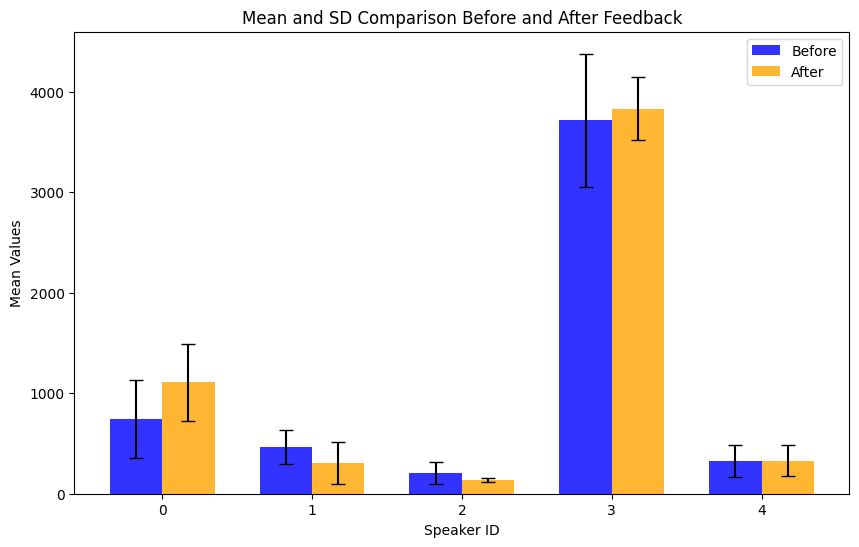

In [105]:
# Separate data for plotting
before_means = results_df[results_df['Condition'] == 'Before']['Mean']
after_means = results_df[results_df['Condition'] == 'After']['Mean']
before_sds = results_df[results_df['Condition'] == 'Before']['SD']
after_sds = results_df[results_df['Condition'] == 'After']['SD']
speaker_ids = results_df[results_df['Condition']
                         == 'Before']['Speaker ID'].unique()

# 그래프 그리기
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(speaker_ids))
bar_width = 0.35

rects1 = ax.bar(index, before_means, bar_width, yerr=before_sds,
                color='blue', label='Before', alpha=0.8, capsize=5)
rects2 = ax.bar(index + bar_width, after_means, bar_width,
                yerr=after_sds, color='orange', label='After', alpha=0.8, capsize=5)

ax.set_xlabel('Speaker ID')
ax.set_ylabel('Mean Values')
ax.set_title('Mean and SD Comparison Before and After Feedback')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(speaker_ids)
ax.legend()

plt.show()

In [106]:
grouped_before = before_feedback.groupby(['speaker_id', 'meeting_number'])[
    'count'].sum().reset_index()
grouped_after = after_feedback.groupby(['speaker_id', 'meeting_number'])[
    'count'].sum().reset_index()

In [111]:
results = []

for speaker_id in range(num_meeting):
    before_feedback_speaker = grouped_before[grouped_before['speaker_id']
                                             == speaker_id]['count']
    after_feedback_speaker = grouped_after[grouped_after['speaker_id']
                                           == speaker_id]['count']

    # t-test 독립표본 검정 수행
    t_statistic, p_value = ttest_ind(
        before_feedback_speaker, after_feedback_speaker)

    # 평균과 표준편차 계산
    mean_before = np.mean(before_feedback_speaker)
    std_before = np.std(before_feedback_speaker)
    mean_after = np.mean(after_feedback_speaker)
    std_after = np.std(after_feedback_speaker)

    # 자유도 계산
    df = len(before_feedback_speaker) + len(after_feedback_speaker) - 2

    # 결과 저장
    results.append({
        "Speaker ID": speaker_id,
        "Condition": "Before",
        "Mean": mean_before,
        "SD": std_before,
        "t-Statistic": t_statistic,
        "df": df,
        "p-Value": p_value
    })

    results.append({
        "Speaker ID": "",
        "Condition": "After",
        "Mean": mean_after,
        "SD": std_after,
        "t-Statistic": "",
        "df": "",
        "p-Value": ""
    })

# 데이터프레임 생성
results_df = pd.DataFrame(results)
results_df

,Speaker ID,Condition,Mean,SD,t-Statistic,df,p-Value
0,0,Before,105.555556,112.630281,-1.234641,10,0.245189
1,,After,204.333333,99.747459,,,
2,1,Before,77.444444,70.403774,0.110801,10,0.913966
3,,After,72.333333,32.998316,,,
4,2,Before,27.333333,11.095545,-1.309224,10,0.219742
5,,After,37.333333,8.259674,,,
6,3,Before,461.888889,488.197466,0.659689,10,0.524355
7,,After,257.000000,91.971010,,,
8,4,Before,63.444444,67.176569,-0.344585,10,0.737543
9,,After,79.000000,41.785165,,,


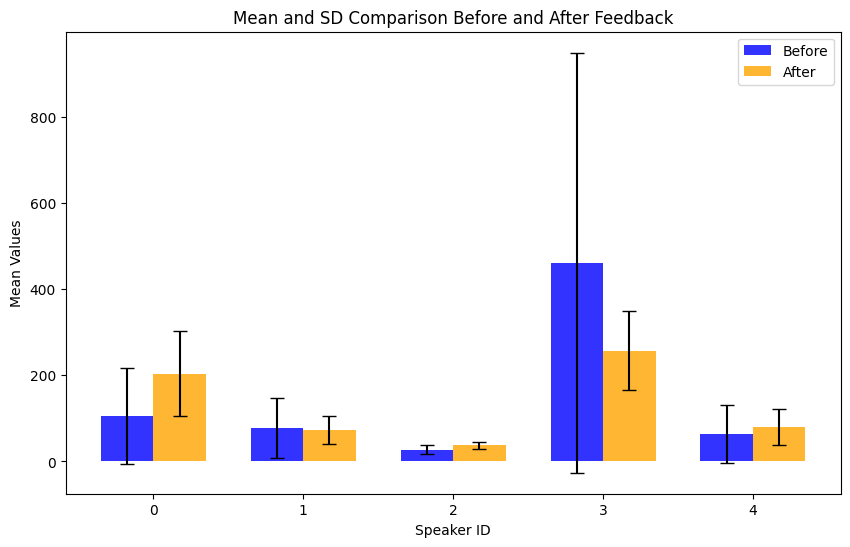

In [112]:
before_means = results_df[results_df['Condition'] == 'Before']['Mean']
after_means = results_df[results_df['Condition'] == 'After']['Mean']
before_sds = results_df[results_df['Condition'] == 'Before']['SD']
after_sds = results_df[results_df['Condition'] == 'After']['SD']
speaker_ids = results_df[results_df['Condition']
                         == 'Before']['Speaker ID'].unique()

fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(len(speaker_ids))
bar_width = 0.35

rects1 = ax.bar(index, before_means, bar_width, yerr=before_sds,
                color='blue', label='Before', alpha=0.8, capsize=5)
rects2 = ax.bar(index + bar_width, after_means, bar_width,
                yerr=after_sds, color='orange', label='After', alpha=0.8, capsize=5)

ax.set_xlabel('Speaker ID')
ax.set_ylabel('Mean Values')
ax.set_title('Mean and SD Comparison Before and After Feedback')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(speaker_ids)
ax.legend()

plt.show()

In [109]:
# # Extract results for each speaker, perform t-test analysis, and generate individual plots
# import matplotlib.pyplot as plt
# from scipy.stats import t

# # Preparing to plot each speaker's t-distribution and p-value area
# fig, axes = plt.subplots(5, 1, figsize=(10, 30), sharex=True)

# for i, ax in enumerate(axes):
#     # Extracting data for each speaker
#     speaker_data = results_df[(results_df['Speaker ID'] == i) & (
#         results_df['Condition'] == 'Before')]
#     t_stat = speaker_data['t-Statistic'].values[0]
#     df = speaker_data['df'].values[0]
#     p_val = speaker_data['p-Value'].values[0]

#     # Define a range for t-values
#     x = np.linspace(-5, 5, 400)
#     y = t.pdf(x, df)

#     # Plotting the t-distribution
#     ax.plot(x, y, label=f'T-distribution (df={df})')

#     # Adding a vertical line for the t-statistic
#     ax.axvline(t_stat, color='red', linestyle='dashed',
#                label=f'T-statistic = {t_stat:.2f}')
#     ax.fill_between(x, 0, y, where=(x > t_stat), color='red',
#                     alpha=0.5, label=f'p-value area (p={p_val:.3f})')

#     # Labels and legend
#     ax.set_title(f'Speaker {i}: T-distribution and p-value area')
#     ax.set_xlabel('t-statistic')
#     ax.set_ylabel('Probability density')
#     ax.legend()
#     ax.grid(True)

# plt.tight_layout()
# plt.show()